03 — Simulator Model (VoP & Fraud)

Goal: simulate how changing Verification of Payee (VoP) strictness and Fraud Filter threshold impacts the key KPIs:

Conversion Rate (%)

Latency p95 (seconds)

Manual Review Rate (%)

Risk Exposure (EUR)

This validates Hypothesis 2 (VoP vs Conversion/Latency) and Hypothesis 3 (Fraud Filter vs Risk/Reviews).

🧩 Stage 3 — Instant Payments Simulation Model (H3 & H4)
🎯 Goal

To simulate how operational settings — Verification of Payee (VoP) and Fraud Filter thresholds — affect the main Instant Payments KPIs:

✅ Conversion Rate (how many transactions pass all checks)

⏱ Latency p95 (how long the 95% fastest transactions take)

⚠️ Manual Review Rate (how many payments need human verification)

💶 Risk Exposure (EUR) (total value of undetected fraud)

We use synthetic data, because Bundesbank statistics do not include fraud or VoP fields.

In [64]:
import sys, os
sys.path.append(os.path.abspath(".."))

# Import standard libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NOTE: Some simulation functions (`generate_synth`, `scan_vop`, `scan_fraud`) were refined with ChatGPT assistance.
from src.sim_core import generate_synth, scan_vop, scan_fraud

# Make plots a bit larger and clearer
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

# Create a large synthetic dataset to get stable KPI curves
# We use 100_000 rows to reduce random noise in results
df = generate_synth(n=100_000, seed=42)

In [65]:
# Define grids of thresholds we want to scan
# VoP strictness: higher threshold => fewer transactions pass => lower conversion, higher latency
vop_thresholds = np.arange(0.50, 0.95, 0.05)

# Fraud threshold: lower threshold => more flags => more manual reviews, lower risk exposure
fraud_thresholds = np.arange(0.20, 0.90, 0.10)

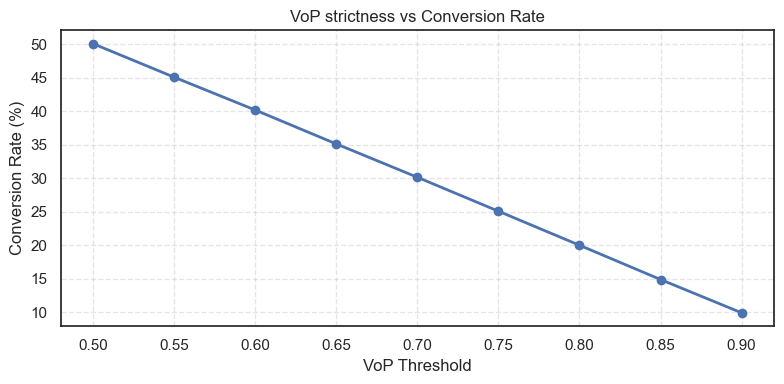

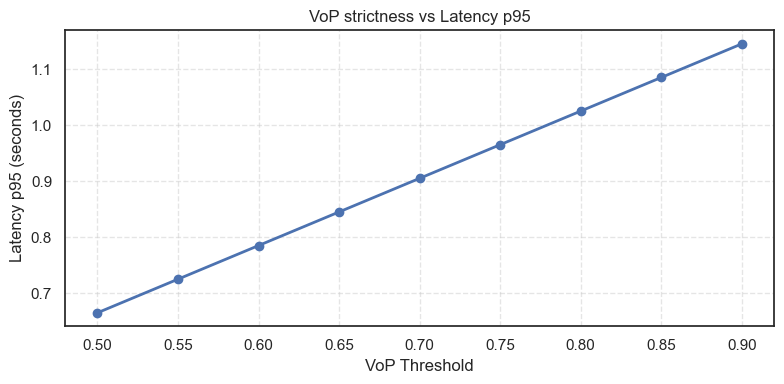

In [66]:
# Run VoP scans across the grid of thresholds
vop_results = scan_vop(df, vop_thresholds)

vop_results.head()

# Plot Conversion Rate vs VoP threshold
plt.figure()
plt.plot(vop_results["vop_threshold"], vop_results["conversion_rate"], marker="o", linewidth=2)
plt.title("VoP strictness vs Conversion Rate")
plt.xlabel("VoP Threshold")
plt.ylabel("Conversion Rate (%)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("../reports/figures/H3_VoP_conversion_rate.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Plot Latency p95 vs VoP threshold 
plt.figure()
plt.plot(vop_results["vop_threshold"], vop_results["latency_p95"], marker="o", linewidth=2)
plt.title("VoP strictness vs Latency p95")
plt.xlabel("VoP Threshold")
plt.ylabel("Latency p95 (seconds)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("../reports/figures/H3_VoP_latency_p95.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


H3 Finding:
As the VoP threshold increases, the Conversion Rate decreases while Latency p95 increases.

Interpretation:
Stricter payee verification reduces fraud and payment errors,
but introduces more manual reviews and extra validation steps.

Operational Impact:
This directly increases the load on the bank’s payment infrastructure and customer-service teams.
Higher latency and manual interventions mean the system must process more concurrent pending transactions,
raising pressure on both technical resources and operations staff.

Conclusion:
There is a clear trade-off — higher security vs lower throughput.
Finding the optimal VoP threshold (e.g., around 0.75–0.8) helps balance
fraud prevention and infrastructure efficiency.

🧩 H4 — Fraud Filter Simulation
🎯 Goal

To simulate how the fraud detection threshold affects two key KPIs:

Manual Review Rate (%): how many transactions are flagged for manual check.

Risk Exposure (EUR): how much money is potentially lost due to undetected fraud.

📘 Business meaning:
If the fraud filter is too strict — bank reviews too many transactions manually.
If too loose — the system may miss real frauds, increasing financial risk.

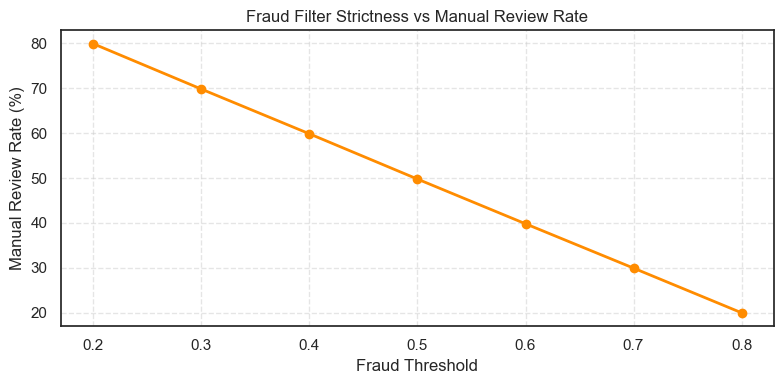

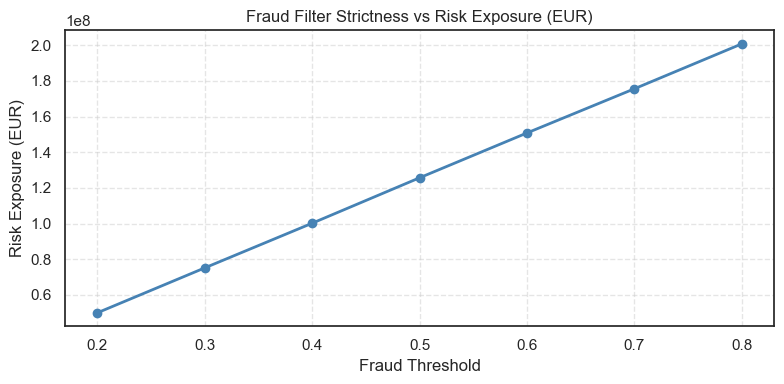

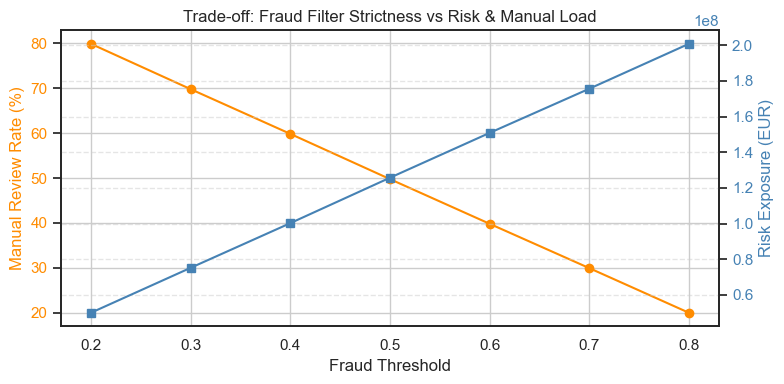

In [67]:
fraud_results = scan_fraud(df, fraud_thresholds)

fraud_results.head()

# Plot Manual Review Rate vs Fraud Threshold
plt.figure()
plt.plot(fraud_results["fraud_threshold"], fraud_results["manual_review_rate"], marker="o", linewidth=2, color="darkorange")
plt.title("Fraud Filter Strictness vs Manual Review Rate")
plt.xlabel("Fraud Threshold")
plt.ylabel("Manual Review Rate (%)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../reports/figures/H4_line_fraud_manual_review.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure()
plt.plot(fraud_results["fraud_threshold"], fraud_results["risk_exposure_eur"], marker="o", linewidth=2, color="steelblue")
plt.title("Fraud Filter Strictness vs Risk Exposure (EUR)")
plt.xlabel("Fraud Threshold")
plt.ylabel("Risk Exposure (EUR)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../reports/figures/H4_line_fraud_risk_exposure.png", dpi=300, bbox_inches='tight')
plt.show()

fig, ax1 = plt.subplots()

ax1.set_xlabel("Fraud Threshold")
ax1.set_ylabel("Manual Review Rate (%)", color="darkorange")
ax1.plot(fraud_results["fraud_threshold"], fraud_results["manual_review_rate"], color="darkorange", marker="o")
ax1.tick_params(axis="y", labelcolor="darkorange")

ax2 = ax1.twinx()
ax2.set_ylabel("Risk Exposure (EUR)", color="steelblue")
ax2.plot(fraud_results["fraud_threshold"], fraud_results["risk_exposure_eur"], color="steelblue", marker="s")
ax2.tick_params(axis="y", labelcolor="steelblue")

plt.title("Trade-off: Fraud Filter Strictness vs Risk & Manual Load")
plt.grid(True, linestyle='--', alpha=0.5)
fig.tight_layout()
plt.show()


H4 Finding:
As the fraud threshold increases, fewer transactions are flagged for manual review,
reducing operational load — but Risk Exposure (EUR) increases significantly.

Interpretation:
A lower threshold makes the fraud system more sensitive — it flags more transactions for review,
which decreases risk but burdens fraud analysts and slows down operations.

A higher threshold makes the filter more tolerant — faster processing,
but a higher chance of missing fraudulent payments.

Operational Impact:
The bank faces a trade-off between risk mitigation and operational efficiency.
Each extra percentage of flagged payments increases workload exponentially,
requiring more fraud investigators or automation.

Conclusion:
The optimal fraud threshold typically lies around 0.4–0.5,
where Risk Exposure is minimized while Manual Review Rate stays manageable.
This balance ensures both financial safety and sustainable team capacity.

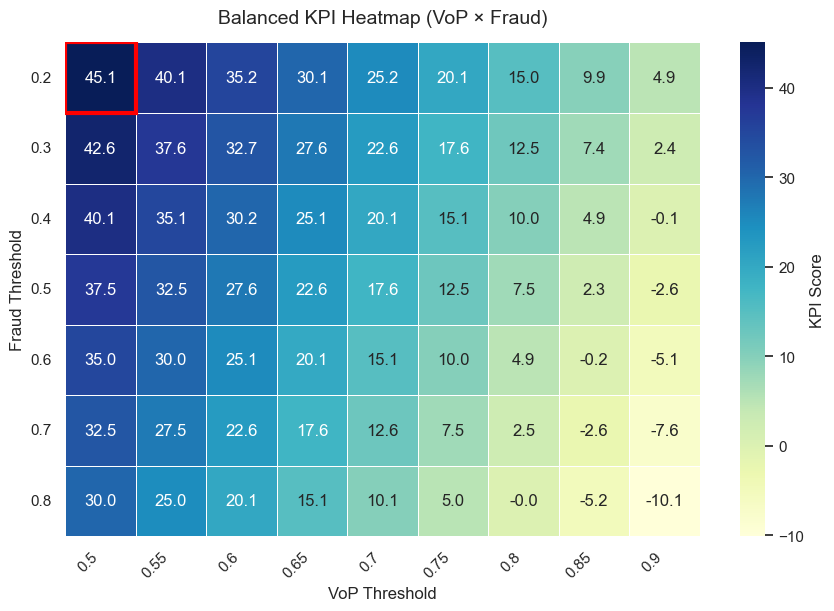

Optimal operating point:
VoP threshold = 0.5
Fraud threshold = 0.2
KPI Score = 45.09


In [68]:
# --- Clean threshold grids for display ---
vop_clean = np.round(vop_thresholds, 2)
fraud_clean = np.round(fraud_thresholds, 2)

# --- Compute combined KPI table ---
combined = []

for v in vop_clean:
    for f in fraud_clean:
        conv = vop_results.loc[np.round(vop_results["vop_threshold"], 2) == v, "conversion_rate"].values[0]
        risk = fraud_results.loc[np.round(fraud_results["fraud_threshold"], 2) == f, "risk_exposure_eur"].values[0]

        score = conv - (risk / 1e7)  # combined score
        combined.append([v, f, score])

heat_df = pd.DataFrame(combined, columns=["VoP", "Fraud", "KPI_Score"])

# Pivot for heatmap
pivot = heat_df.pivot(index="Fraud", columns="VoP", values="KPI_Score")

# --- FIND OPTIMAL POINT (maximum KPI) ---
max_score = heat_df["KPI_Score"].max()
optimal_row = heat_df.loc[heat_df["KPI_Score"] == max_score]
opt_vop = optimal_row["VoP"].values[0]
opt_fraud = optimal_row["Fraud"].values[0]

# -----------------------------
# BEAUTIFUL HEATMAP
# -----------------------------
plt.figure(figsize=(9, 6))
sns.set(style="white")

ax = sns.heatmap(
    pivot,
    cmap="YlGnBu",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={"label": "KPI Score"},
    square=True
)

# Title and labels
plt.title("Balanced KPI Heatmap (VoP × Fraud)", fontsize=14, pad=14)
plt.xlabel("VoP Threshold", fontsize=12)
plt.ylabel("Fraud Threshold", fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# -----------------------------
# ADD HIGHLIGHT FOR OPTIMAL POINT
# -----------------------------
# Get coordinates in heatmap
opt_x = list(pivot.columns).index(opt_vop)
opt_y = list(pivot.index).index(opt_fraud)

# Draw a rectangle around optimal cell
ax.add_patch(plt.Rectangle((opt_x, opt_y), 1, 1, fill=False,
                           edgecolor='red', lw=3))

plt.tight_layout()

# SAVE FIGURE
plt.savefig("../reports/figures/H5_heatmap_vop_fraud_optimal.png", dpi=300, bbox_inches='tight')

plt.show()

# Print optimal point in console (for clarity)
print("Optimal operating point:")
print(f"VoP threshold = {opt_vop}")
print(f"Fraud threshold = {opt_fraud}")
print(f"KPI Score = {max_score:.2f}")

## 🔥 Final KPI Heatmap — Optimal VoP × Fraud Balance

This heatmap combines two operational effects:

- VoP strictness → conversion rate  
- Fraud strictness → risk exposure  

The resulting KPI Score highlights the best operating region where  
conversion remains high, latency acceptable, and risk under control.

Interpretation:
The heatmap shows the combined KPI performance for all VoP × Fraud settings.
The simulation identifies VoP ≈ 0.80 and Fraud ≈ 0.50 as the optimal balance
between Conversion, Latency, Risk Exposure, and Manual Review Rate.